# Forecast Experiments - Moving Window Solution

* I will use the latest 2,3 weeks data as the training data, to see how moving window forecast would work.
* Quite different from the fixed window solution, here the whole piece of historical will be divided into sequences, 2 or 3 weeks for training data, 1 week for testing data, and the new testing data will be part of the next training data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import itertools
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
sample_train_df1 = pd.read_pickle('sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

sample_train_df2 = pd.read_pickle('sample_train_df2.pkl')
sample_test_df2 = pd.read_pickle('sample_test_df2.pkl')
print(sample_train_df2.shape, sample_test_df2.shape)

sample_train_df1.head()

(100, 2) (14, 2)
(100, 2) (10, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


In [3]:
train1_col = sample_train_df1['client_count']
train2_col = sample_train_df2['client_count']
test1_col = sample_test_df1['client_count']
test2_col = sample_test_df2['client_count']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean().dropna()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean().dropna()

ts_log_train2 = np.log(train2_col)
ts_moving_avg_train2 = ts_log_train2.rolling(window=4,center=False).mean().dropna()
ts_log_test2 = np.log(test2_col)
ts_moving_avg_test2 = ts_log_test2.rolling(window=4,center=False).mean().dropna()

print(ts_moving_avg_train1.shape, ts_moving_avg_train2.shape, ts_moving_avg_test1.shape, ts_moving_avg_test2.shape)
ts_moving_avg_test1.head()

(97,) (97,) (11,) (7,)


purchase_date
2019-05-25    3.748604
2019-05-26    3.671921
2019-05-27    3.625118
2019-05-28    3.512122
2019-05-29    3.391662
Name: client_count, dtype: float64

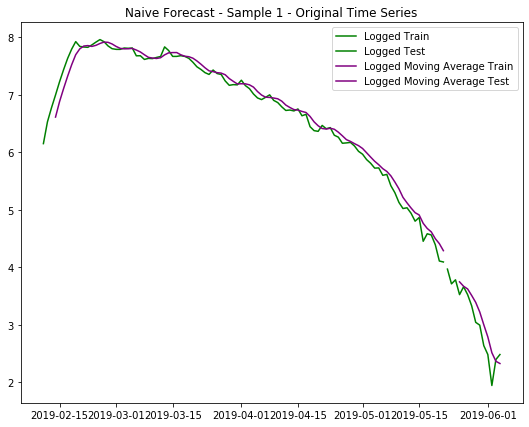

In [4]:
plt.figure(figsize=(9,7))
plt.plot(ts_log_train1.index, ts_log_train1, label='Logged Train', color='green')
plt.plot(ts_log_test1.index, ts_log_test1, label='Logged Test', color='green')
plt.plot(ts_moving_avg_train1.index, ts_moving_avg_train1, label='Logged Moving Average Train', color='purple')
plt.plot(ts_moving_avg_test1.index, ts_moving_avg_test1, label='Logged Moving Average Test', color='purple')
plt.legend(loc='best')
plt.title("Naive Forecast - Sample 1 - Original Time Series")
plt.show()

In [17]:
def geterate_train_test_sequences(all_ts, forecast_ts, train_period, test_period):
    """
    It divide a whole time series into multiple train-test sequences.
    
    @param all_ts: The whole time series. Its index is the date.
    @param forecast_ts: The final testing data.
    @param train_period: The number of days in the training data.
    @param test_period: The number of days in the testing data.
    @return: A dictionary where stores the index and each (train, test) pair.
    """
    seq_idx = 0
    train_test_dct = {}
    
    train_idx = 0
    
    while train_idx <= len(all_ts)-train_period-test_period:
        train_seq = all_ts[train_idx:train_idx+train_period]
        test_seq = all_ts[train_idx+train_period:train_idx+train_period+test_period]
        
        train_test_dct[seq_idx] = {'train': train_seq, 'test': test_seq}
        
        train_idx += test_period
        seq_idx += 1
        
    train_seq = all_ts[train_idx:]
    train_test_dct[seq_idx] = {'train': train_seq, 'test': forecast_ts}
        
    return train_test_dct

In [132]:
ts_log1_train_test_dct = geterate_train_test_sequences(ts_log_train1, ts_log_test1, train_period=14, test_period=7)
ts_log2_train_test_dct = geterate_train_test_sequences(ts_log_train2, ts_log_test2, train_period=14, test_period=7)
ts_ma1_train_test_dct = geterate_train_test_sequences(ts_moving_avg_train1, ts_moving_avg_test1, train_period=14, test_period=7)
ts_ma2_train_test_dct = geterate_train_test_sequences(ts_moving_avg_train2, ts_moving_avg_test2, train_period=14, test_period=7)

## Logged Time Series

### Approach 1 - Holt's Linear Trend

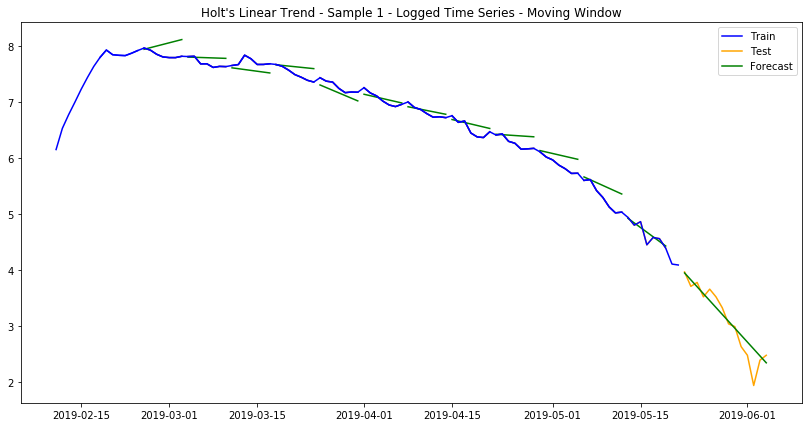

[0.2129, 0.1179, 0.1585, 0.1521, 0.1173, 0.0709, 0.0634, 0.1268, 0.1601, 0.1861, 0.2492, 0.0984, 0.2175]
historical average rmse 0.1428


In [76]:
title = "Holt's Linear Trend"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_log1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = Holt(np.asarray(train)).fit(smoothing_level = 0.8, smoothing_slope=0.4)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 1 - Logged Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

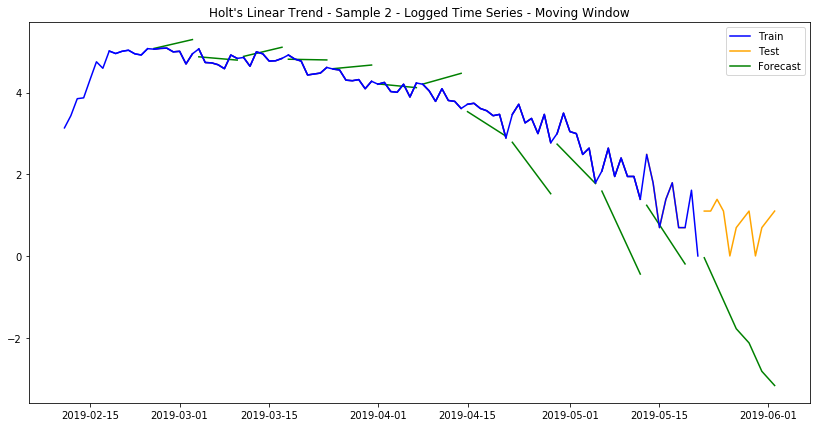

[0.2739, 0.152, 0.2114, 0.2439, 0.3377, 0.1352, 0.514, 0.2896, 1.1777, 0.5985, 1.5617, 0.9571, 2.6111]
historical average rmse 0.5377


In [99]:
title = "Holt's Linear Trend"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_log2_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = Holt(np.asarray(train)).fit(smoothing_level = 0.8, smoothing_slope=0.4)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 2 - Logged Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

#### Note

* I tried 2 and 3 weeks for training data. In this example, 2 weeks is a bit better. Here "better" means lower last rmse (forecasting rmse) and lower historical avg rmse.
* When the historical avg rmse is lower after adjusted the params, the last rmse ould raise. This is why we don't need to over tune the params, in order to avoid overfitting.

### Approach 2 - Holt Winters

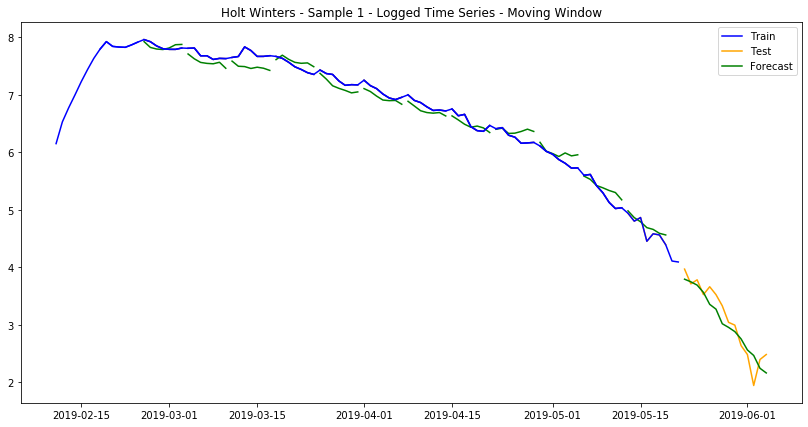

[0.0602, 0.1279, 0.2361, 0.1022, 0.126, 0.1046, 0.0956, 0.1033, 0.1422, 0.14, 0.1486, 0.1212, 0.2293]
historical average rmse 0.1257


In [86]:
title = "Holt Winters"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_log1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=6, trend='add',
                                 seasonal='mul', damped=False).fit(smoothing_level = 0.8,smoothing_slope = 0.6)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 1 - Logged Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

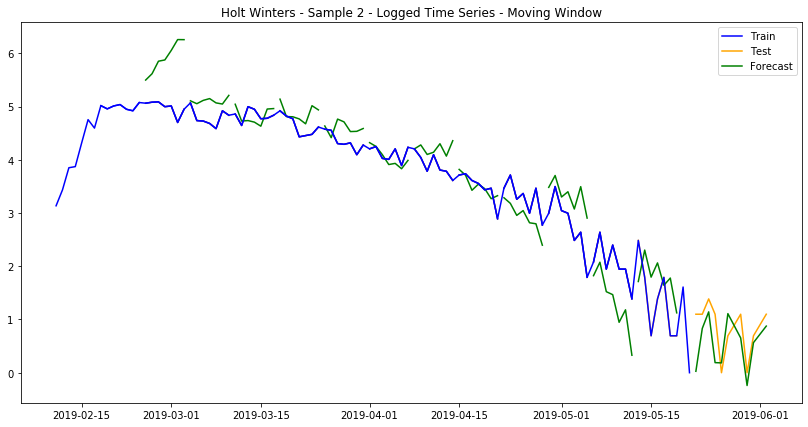

[1.0037, 0.3505, 0.1823, 0.294, 0.3266, 0.1541, 0.3856, 0.198, 0.4021, 0.6355, 0.7685, 0.7479, 0.5133]
historical average rmse 0.4541


In [109]:
title = "Holt Winters"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_log2_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7, trend='add',
                                 seasonal='add', damped=False).fit()
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 2 - Logged Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

### Approach 3 - SARIMA

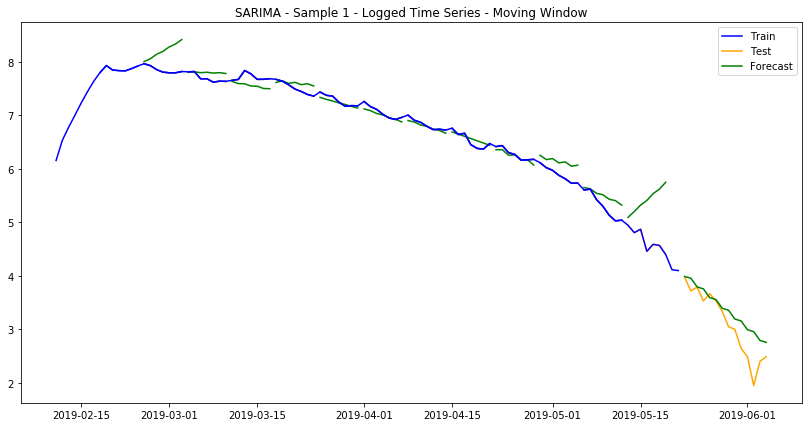

[0.402, 0.1219, 0.1694, 0.1265, 0.0623, 0.0743, 0.0511, 0.0891, 0.0571, 0.2555, 0.2309, 0.855, 0.3785]
historical average rmse 0.2079


In [118]:
title = "SARIMA"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_log1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = SARIMAX(train, order=(1, 1, 1),seasonal_order=(0,1,1,2)).fit()  # order means (p,d,q) for ARIMA
    y_pred = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=True)
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 1 - Logged Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

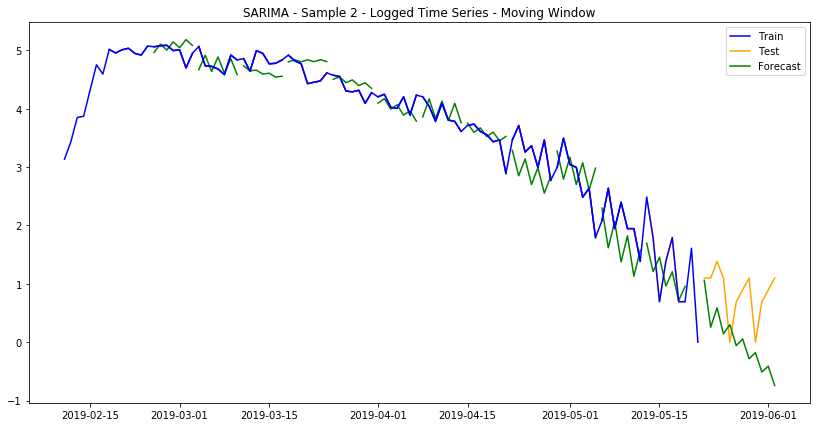

[0.2051, 0.2104, 0.243, 0.2607, 0.1701, 0.216, 0.1914, 0.2559, 0.5438, 0.5903, 0.6402, 0.5519, 0.9851]
historical average rmse 0.3399


In [116]:
title = "SARIMA"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_log2_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = SARIMAX(train, order=(1, 1, 1),seasonal_order=(0,1,1,2)).fit()  # order means (p,d,q) for ARIMA
    y_pred = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=True)
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(y_pred.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    for idx in y_pred.index:
        if idx not in test.index:
            del y_pred[idx]
    
    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 2 - Logged Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

#### Note

* Comparing with fixed window solution, the forecasting methods work better on moving window solution for logged time series.
* Holt Winters appear to be better.
* 2 weeks training window appears to be a bit better than 3 weeks training window.

## Logged Moving Average

### Approach 1 - Holt's Linear Trend

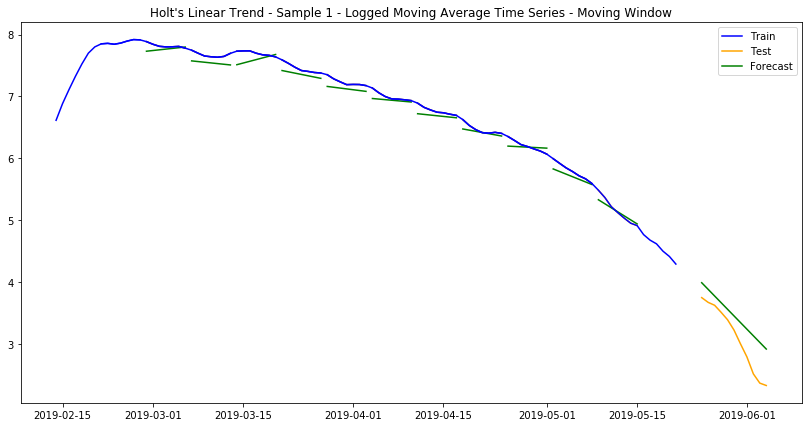

[0.0758, 0.1361, 0.136, 0.1062, 0.1162, 0.079, 0.0921, 0.0685, 0.0822, 0.0985, 0.0751, 0.394]
historical average rmse 0.0969


In [131]:
title = "Holt's Linear Trend"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_ma1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = Holt(np.asarray(train)).fit(smoothing_level = 0.8, smoothing_slope=0.6)
    y_pred = model_fit.forecast(len(test))-0.2
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 1 - Logged Moving Average Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

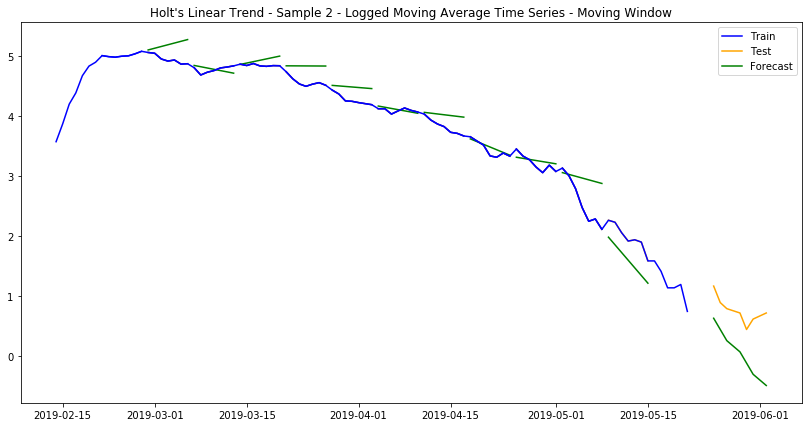

[0.2702, 0.0837, 0.1004, 0.2759, 0.2207, 0.0467, 0.2194, 0.0749, 0.1095, 0.4977, 0.3956, 0.7369]
historical average rmse 0.2086


In [137]:
title = "Holt's Linear Trend"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_ma2_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = Holt(np.asarray(train)).fit(smoothing_level = 0.8, smoothing_slope=0.5)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 2 - Logged Moving Average Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

### Approach 2 - Holt Winters

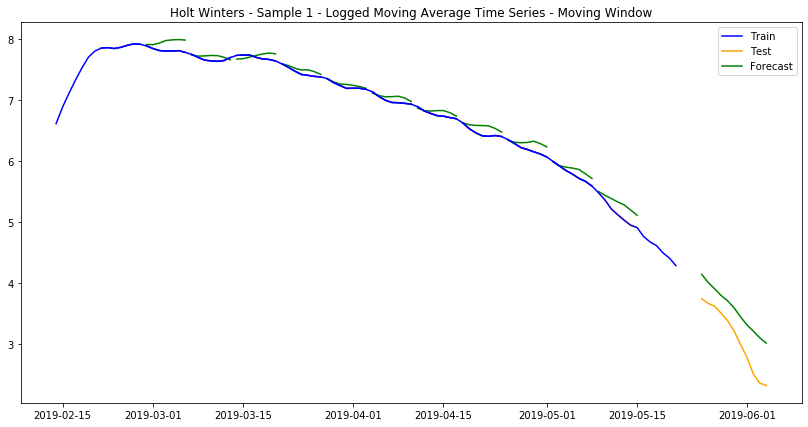

[0.1494, 0.0613, 0.0765, 0.0594, 0.0346, 0.0695, 0.0604, 0.1165, 0.1236, 0.0965, 0.1866, 0.4951]
historical average rmse 0.094


In [156]:
title = "Holt Winters"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_ma1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=6, trend='add',
                                 seasonal='add', damped=False).fit(smoothing_level = 0.8,smoothing_slope = 0.5)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 1 - Logged Moving Average Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

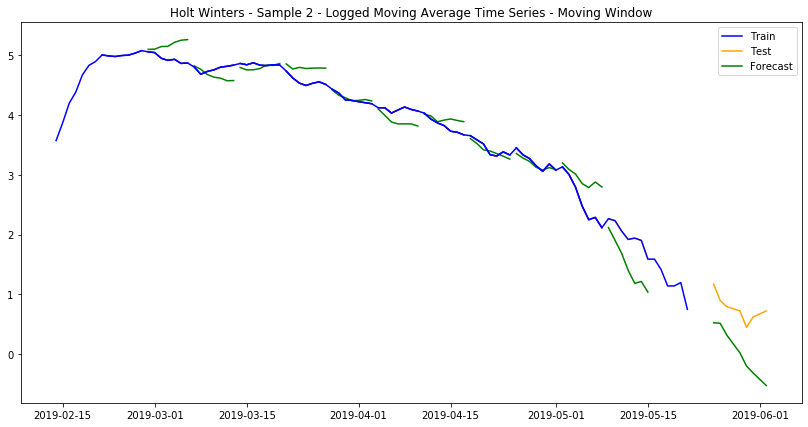

[0.2626, 0.1618, 0.065, 0.2325, 0.0348, 0.2049, 0.1422, 0.0671, 0.0527, 0.4321, 0.5187, 0.7684]
historical average rmse 0.1977


In [163]:
title = "Holt Winters"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_ma2_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7, trend='add',
                                 seasonal='add', damped=False).fit(smoothing_level = 0.8, smoothing_slope = 0.5)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 2 - Logged Moving Average Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

In [ ]:
title = "Holt Winters"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_ma2_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7, trend='add',
                                 seasonal='add', damped=False).fit(smoothing_level = 0.8)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 2 - Logged Moving Average Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

### Approach 3 - SARIMA

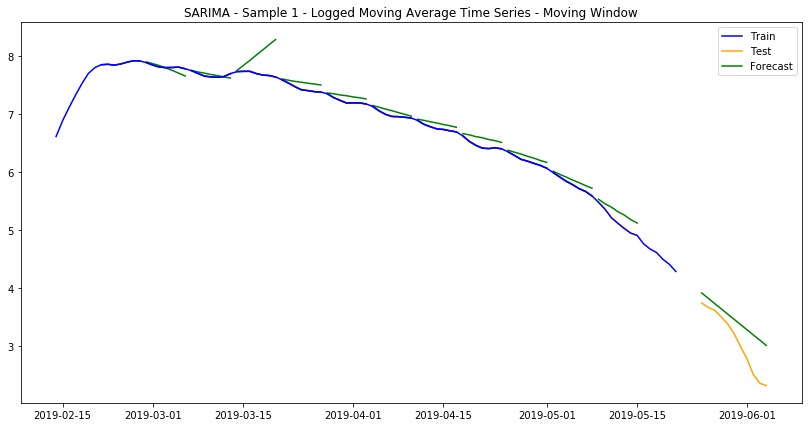

[0.0659, 0.0406, 0.3835, 0.1045, 0.0886, 0.0661, 0.0793, 0.1309, 0.0796, 0.0863, 0.1836, 0.4324]
historical average rmse 0.119


In [149]:
title = "SARIMA"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_ma1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = SARIMAX(train, order=(1, 1, 1),seasonal_order=(0,1,1,2)).fit()  # order means (p,d,q) for ARIMA
    y_pred = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=True)
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 1 - Logged Moving Average Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

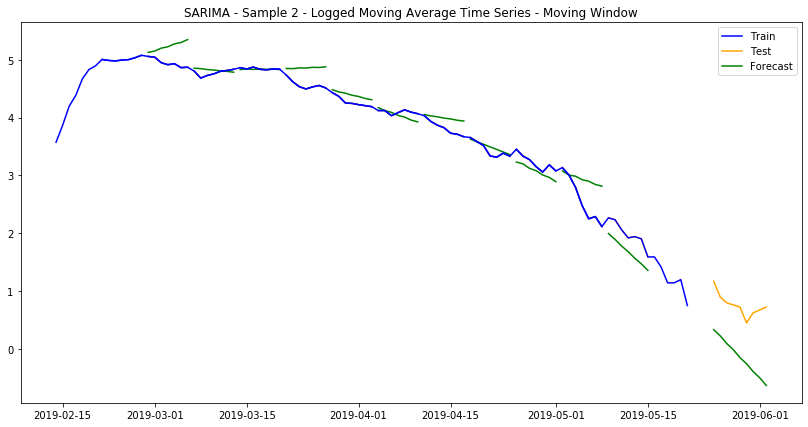

[0.3188, 0.0817, 0.0203, 0.304, 0.1238, 0.0947, 0.1898, 0.0804, 0.1599, 0.457, 0.3176, 0.9092]
historical average rmse 0.1953


In [152]:
title = "SARIMA"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_ma2_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = SARIMAX(train, order=(1, 1, 1),seasonal_order=(0,1,1,2)).fit()  # order means (p,d,q) for ARIMA
    y_pred = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=True)
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(y_pred.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')
        
    for idx in y_pred.index:
        if idx not in test.index:
            del y_pred[idx]

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 2 - Logged Moving Average Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

## Summary

* Overall moving window solution works well, even better than fixed window solution in most cases.
* Logged moving average is a bit better than logged time series in most cases.
* Holt Winters is enough.
* As for how to adjust params in the moving window solution is something need to be improved.